### NoteBook Contents : (Comparing And Selecting Best ML Model on train data with kFoldCrossValidation)
        > 1. Loading the Standard Scaled training data
        > 2. Creating 5-folds for cross validation in the dataset 
        > 3. Definig several classification Machine Learning models 
        > 4. Training above models on the train data with 5-fold cross validation and recording F1 metric in each fold
        > 5. Perfomance & Time taken to train Comparision for selecting best performing classifier

#### Importing Essential Data handling libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

import time
from math import floor
from time import perf_counter
from tqdm import tqdm

pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [8]:
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import model_selection

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

### 1. Loading the Standard Scaled training data

In [3]:
train_df = pd.read_csv("..\\1_Modeling_Data_After_Transformations_TestTrainSplits\\Training_data_std.csv") ## looking for dataset up one directory

In [4]:
train_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,-0.286,0.811,0.182,0.847,-0.812,-0.468,-0.398,-0.383,-0.339,-0.309,-0.317,-0.691,-0.589,-0.671,-0.610,-0.654,-0.648,0.101,-0.231,-0.063,-0.270,-0.286,-0.146,0
1,1.414,-1.233,-1.080,0.847,1.787,-0.468,-0.398,-0.383,-0.339,-0.309,-0.317,-0.687,-0.661,-0.666,-0.660,-0.644,-0.566,-0.205,-0.217,-0.243,-0.232,0.029,-0.011,0
2,0.719,-1.233,0.182,0.847,-0.379,0.842,-0.398,-0.383,-0.339,-0.309,-0.317,-0.648,-0.693,-0.677,-0.644,-0.647,-0.654,-0.341,-0.247,-0.184,-0.241,-0.311,-0.292,0
3,0.873,0.811,0.182,0.847,-0.596,-0.468,-0.398,-0.383,-0.339,-0.309,-0.317,0.140,0.060,-0.423,-0.674,-0.574,-0.654,0.130,-0.074,-0.291,0.040,-0.311,-0.273,0
4,-0.672,0.811,0.182,-1.070,-1.137,-0.468,-0.398,-0.383,-0.339,-0.309,-0.317,0.342,0.388,-0.014,0.076,0.129,0.155,-0.204,-0.156,-0.114,-0.178,-0.182,-0.179,0


### 2. Creating 5-folds for cross validation in the dataset 

In [5]:
target = "default payment next month"

In [6]:
def create_stratified_folds(data, k_fold_num, target_variable):
    data["kfold"] = -1 # we create a new column called kfold and fill it with -1
    data = data.sample(frac=1).reset_index(drop=True) # the next step is to randomize the rows of the data

    y = data[target_variable].values

    kf = model_selection.StratifiedKFold(n_splits= k_fold_num)

    for fold, (trn_, partitioned_idx_) in enumerate(kf.split(X=data, y = y)):
        data.loc[partitioned_idx_, 'kfold'] = fold
    return(data)

In [9]:
# Creating stratified k-fold within the data
df = train_df.copy()

k_fold_num = 5

df = create_stratified_folds(df, k_fold_num = 5, target_variable = target)

features = [f for f in df.columns if f not in ["kfold",target]]

In [10]:
df.kfold.value_counts()

0    4800
1    4800
2    4800
3    4800
4    4800
Name: kfold, dtype: int64

### 3. Definig several classification Machine Learning models 

##### defining models

##### Performance metric : Accuracy

In [11]:
## Initializing some Vanila models for performance comparision

models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('Decision Tree', DecisionTreeClassifier(max_depth = 20)))
models.append(('Random Forest', RandomForestClassifier(n_estimators=250, n_jobs=-1))) # setting n_jobs = -1 to utilze all cores for training 
models.append(('K-Nearest Neighbors', KNeighborsClassifier(n_neighbors=11, n_jobs=-1)))
models.append(('Ada Boost', AdaBoostClassifier(n_estimators=250)))

In [12]:
# for name, model in models:
#     print(name)
#     print(model)
#     print("\n")

### 4. Training above models on the train data with 5-fold cross validation and recording F1 score in each fold

In [13]:
LogisticRegression().fit(train_df.iloc[:,:-1], train_df.iloc[:,-1]).predict_proba(train_df.iloc[:,:-1])[:,1]

array([0.12433548, 0.13094848, 0.25544678, ..., 0.18312633, 0.09675561,
       0.11005867])

In [14]:
F1_score_results = {}
time_taken = {}

for name, model in models:
    t0 = perf_counter()
    
    f1_scores = []
    for fold in range(k_fold_num):
        df_train = df[df.kfold != fold].reset_index(drop=True)
        df_valid = df[df.kfold == fold].reset_index(drop=True)

        x_train = df_train[features].values
        x_valid = df_valid[features].values
        
        model.fit(x_train, df_train[target].values)
        
        valid_pred = model.predict(x_valid)
        
        f1 = f1_score(df_valid[target].values, valid_pred)
        f1_scores.append(np.round(f1,4))
        
    t1 = perf_counter()
    
    F1_score_results[name] = f1_scores
    time_taken[name] = np.round((t1 - t0)/60,2)
    
    print("Model : ", name)
    print("Average F1 score = ", np.round(np.mean(f1_scores),2))
    print("Time Taken in minutes = ", time_taken[name])
    print("\n")

Model :  Logistic Regression
Average F1 score =  0.44
Time Taken in minutes =  0.0


Model :  Decision Tree
Average F1 score =  0.41
Time Taken in minutes =  0.02


Model :  Random Forest
Average F1 score =  0.46
Time Taken in minutes =  0.08


Model :  K-Nearest Neighbors
Average F1 score =  0.44
Time Taken in minutes =  0.26


Model :  Ada Boost
Average F1 score =  0.44
Time Taken in minutes =  0.51




In [15]:
# 5 fold cross validation f1 scores of above models
F1_score_results

{'Logistic Regression': [0.4586, 0.4396, 0.4258, 0.4576, 0.4015],
 'Decision Tree': [0.414, 0.4163, 0.3792, 0.4234, 0.3967],
 'Random Forest': [0.4818, 0.4668, 0.4402, 0.4714, 0.4464],
 'K-Nearest Neighbors': [0.461, 0.4453, 0.4251, 0.4591, 0.4192],
 'Ada Boost': [0.4518, 0.4585, 0.4243, 0.4524, 0.4104]}

In [16]:
time_taken

{'Logistic Regression': 0.0,
 'Decision Tree': 0.02,
 'Random Forest': 0.08,
 'K-Nearest Neighbors': 0.26,
 'Ada Boost': 0.51}

### 5. "Perfomance" & "Time taken to train" Comparision for selecting best performing classifier

##### Plotting the F1_score_results ditribution for comparing the algorithms

Text(0.5, 0, 'Model')

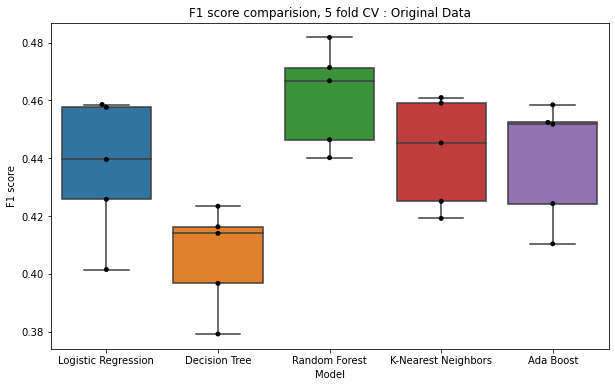

In [17]:
Accuracy_score_results_df = pd.DataFrame(F1_score_results)
plt.figure(figsize=(10, 6))
sns.boxplot(data=Accuracy_score_results_df)
sns.swarmplot(data=Accuracy_score_results_df, color = "black")
plt.title("F1 score comparision, 5 fold CV : Original Data")
plt.ylabel("F1 score")
plt.xlabel("Model")

##### Plotting the time taken in training 5fold CV for comparing the algorithms

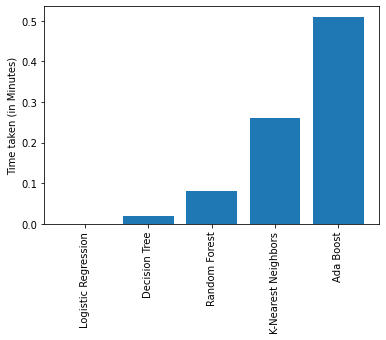

In [18]:
plt.bar(*zip(*time_taken.items()), )
plt.ylabel("Time taken (in Minutes)")
plt.xticks(rotation=90)
plt.show()

#### From above 2 charts, I am selecting RandomForest to be the best classifier for training the model. 

##### Next, We will tune the Hyperparameters of the Random Forest Model in hope to increase the performance of the classifier